## Лабораторная № 4. Обучение рекурентной нейронной сети

Скачайте датасет с фамилиями разных национальностей, используемый на практическом
занятии. Необходимо обучить несколько рекурентных нейронных сетей для
классификации фамилий по национальностям. Нейронные сети должны отличаться
гиперпараметрами.

In [ ]:
from argparse import Namespace
import os
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
# to solve error "The kernel for *.ipynb appears to have died. It will restart automatically."
# https://www.kaggle.com/product-feedback/41221
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
import pandas as pd

df = pd.read_csv('surnames_with_splits.csv')
df.head(10)

,surname,nationality,split
0,Totah,Arabic,train
1,Abboud,Arabic,train
2,Fakhoury,Arabic,train
3,Srour,Arabic,train
4,Sayegh,Arabic,train
5,Cham,Arabic,train
6,Haik,Arabic,train
7,Kattan,Arabic,train
8,Khouri,Arabic,train
9,Antoun,Arabic,train


In [ ]:
# Подсчет количества каждой категории
split_counts = df['split'].value_counts()

# Расчет процента для каждой категории
percentages = split_counts / len(df) * 100

# Вывод результатов
print(percentages)

train    69.945355
test     15.118397
val      14.936248
Name: split, dtype: float64


~ 70% training data,

~15% validation data

~ 15% test data.

In [ ]:
split_counts

train    7680
test     1660
val      1640
Name: split, dtype: int64

### Vocabulary, Vectorizer, Dataset

In [ ]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}


    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary

        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index

        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [ ]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def lookup_token(self, token):
        """Retrieve the index associated with the token
          or the UNK index if token isn't present.

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
              for the UNK functionality
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [ ]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, char_vocab, nationality_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            title (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token)
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index

        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

In [ ]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size)}

        self.set_split('train')

        # Class weights
        class_counts = self.train_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)


    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch

        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))


    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets

        Args:
            index (int): the index to the data point
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]

        surname_vector, vec_length = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector,
                'y_target': nationality_index,
                'x_length': vec_length}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size



def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

### Baseline model: RNN (с практики)


nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)

nn.RNN(input_size=embedding_size,
                           hidden_size=rnn_hidden_size,
                           batch_first=batch_first)

nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)

nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

In [ ]:
def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)


class SurnameClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector
                Note: the number of nationalities
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding;
                see torch.nn.Embedding
        """
        super(SurnameClassifier, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        self.rnn = nn.RNN(input_size=embedding_size,
                           hidden_size=rnn_hidden_size,
                           batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out, _ = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(y_out))
        y_out = self.fc2(y_out)
        # y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        # y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

In [ ]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

#### Parameters of RNN Baseline Model
- Epoch = 25
- char_embedding_size=100
- rnn_hidden_size=64
- batch_size=64
- Optimizer = Adam
- learning_rate=1e-3
- Learning rate schedule: lr_scheduler.ReduceLROnPlateau

In [ ]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=64,
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [ ]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [ ]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
classifier = classifier.to(args.device)
#dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}
import time as t
t1 = t.perf_counter()

try:
    for epoch_index in tqdm(range(args.num_epochs)):
        train_state['epoch_index'] = epoch_index

        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                            batch_size=args.batch_size,
                                            device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            optimizer.zero_grad()
            y_pred = classifier(x_in=batch_dict['x_data'],
                                x_lengths=batch_dict['x_length'])

            loss = loss_func(y_pred, batch_dict['y_target'])

            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            loss.backward()

            optimizer.step()
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                          batch_size=args.batch_size,
                                          device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            y_pred = classifier(x_in=batch_dict['x_data'],
                                x_lengths=batch_dict['x_length'])

            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        scheduler.step(train_state['val_loss'][-1])
        '''
        if train_state['stop_early']:
            break
        '''
except KeyboardInterrupt:
    print("Exiting loop")


print('-----')
t2 = t.perf_counter()
print("Running time = {:.2f}".format(t2-t1))


  0%|          | 0/25 [00:00<?, ?it/s]

-----
Running time = 66.03


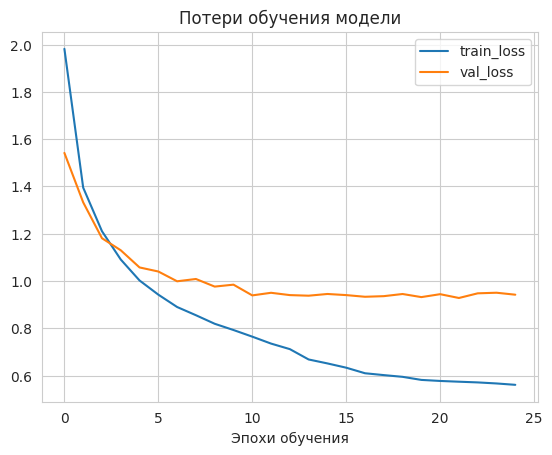

In [ ]:
loss_labels = ["train_loss", "val_loss"]

for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.title("Потери обучения модели")
    plt.xlabel("Эпохи обучения")
plt.legend()

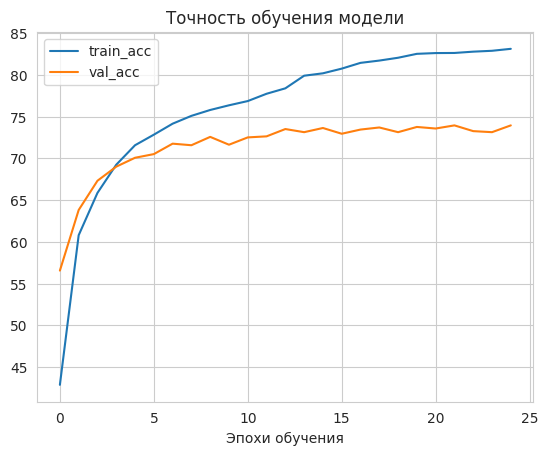

In [ ]:
acc_labels = ["train_acc", "val_acc"]
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.title("Точность обучения модели")
    plt.xlabel("Эпохи обучения")
plt.legend()

In [ ]:
y #точность до переобучения - 71.75000000000001, что соответсвует 6 эпохе

[56.5625,
 63.81250000000001,
 67.31250000000001,
 69.0,
 70.06249999999997,
 70.49999999999999,
 71.75000000000001,
 71.56249999999999,
 72.5625,
 71.62500000000001,
 72.5,
 72.62499999999999,
 73.49999999999999,
 73.125,
 73.62500000000001,
 72.9375,
 73.43750000000001,
 73.6875,
 73.125,
 73.74999999999999,
 73.5625,
 73.9375,
 73.25000000000001,
 73.125,
 73.93749999999999]

### Проведите два эксперимента-исследования при изменении гиперпараметров,cформулируйте выводы:

• **Измените архитектуру нейронной сети** (например, RNN, LSTM, GRU и т.д.),

self.rnn = nn.RNN(input_size=embedding_size, hidden_size=rnn_hidden_size, batch_first=batch_first)


#### Добавим LeakyReLU активатор и Batch Normalization


nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)

nn.RNN(input_size=embedding_size,
                           hidden_size=rnn_hidden_size,
                           batch_first=batch_first)

**nn.Sequential**(
            nn.Linear(in_features=rnn_hidden_size,out_features=rnn_hidden_size),
            **nn.BatchNorm1d(rnn_hidden_size), nn.LeakyReLU()**)

nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)


##### Параметры модели и обучения оставим теми же

In [ ]:
class SurnameClassifier_modified(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector
                Note: the number of nationalities
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding;
                see torch.nn.Embedding
        """
        super(SurnameClassifier_modified, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)

        self.rnn = nn.RNN(input_size=embedding_size,
                           hidden_size=rnn_hidden_size,
                           batch_first=batch_first)

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=rnn_hidden_size,out_features=rnn_hidden_size),
            nn.BatchNorm1d(rnn_hidden_size), nn.LeakyReLU())

        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out, _ = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(y_out))
        y_out = self.fc2(y_out)
        # y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        # y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

In [ ]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=64,
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [ ]:
classifier_modified = SurnameClassifier_modified(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [ ]:
classifier_modified = classifier_modified.to(args.device)
#dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_modified.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}
import time as t
t1 = t.perf_counter()


try:
    for epoch_index in tqdm(range(args.num_epochs)):
        train_state['epoch_index'] = epoch_index

        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                            batch_size=args.batch_size,
                                            device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier_modified.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            optimizer.zero_grad()
            y_pred = classifier_modified(x_in=batch_dict['x_data'],
                                x_lengths=batch_dict['x_length'])

            loss = loss_func(y_pred, batch_dict['y_target'])

            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            loss.backward()

            optimizer.step()
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                          batch_size=args.batch_size,
                                          device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier_modified.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            y_pred = classifier_modified(x_in=batch_dict['x_data'],
                                x_lengths=batch_dict['x_length'])

            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        scheduler.step(train_state['val_loss'][-1])
        '''
        if train_state['stop_early']:
            break
        '''
except KeyboardInterrupt:
    print("Exiting loop")


print('-----')
t2 = t.perf_counter()
print("Running time = {:.2f}".format(t2-t1))

  0%|          | 0/25 [00:00<?, ?it/s]

-----
Running time = 67.87


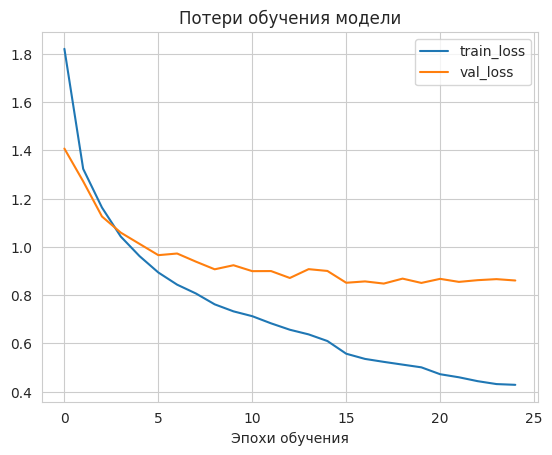

In [ ]:
loss_labels = ["train_loss", "val_loss"]

for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.title("Потери обучения модели")
    plt.xlabel("Эпохи обучения")
plt.legend()

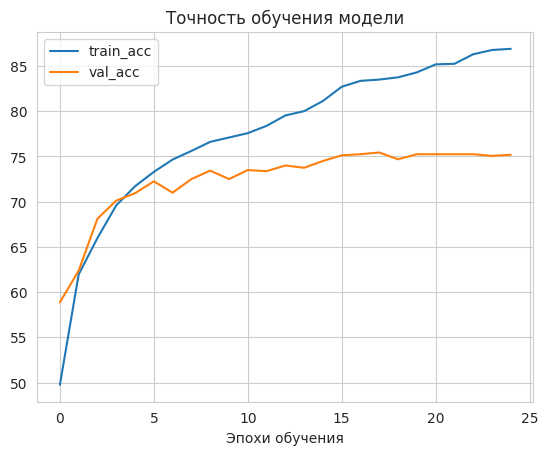

In [ ]:
acc_labels = ["train_acc", "val_acc"]
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.title("Точность обучения модели")
    plt.xlabel("Эпохи обучения")
plt.legend()

In [ ]:
y #точность до переобучения - 72.25000000000001, что соответсвует 5 эпохе

[58.874999999999986,
 62.375,
 68.125,
 70.125,
 70.9375,
 72.25000000000001,
 71.00000000000001,
 72.5,
 73.4375,
 72.50000000000003,
 73.5,
 73.37500000000001,
 73.99999999999999,
 73.75000000000001,
 74.5,
 75.125,
 75.24999999999999,
 75.4375,
 74.6875,
 75.25,
 75.25,
 75.25,
 75.24999999999999,
 75.06249999999999,
 75.18750000000003]

#### Выводы по изменнной архитектуре: добавление Leaky ReLU и BatchNorm

По графикам бейзлайна можно заметить, что после ~6 эпохи происходит переобучение. Точность до момента переобучения составляет **71.75**.

Также с 1 по 3 эпоху может наблюдаться небольшое недообучение, тк точность на тренировочном наборе данных была немного ниже нежели на валидационном. Однако разница незначительна.

С целью улучшения качества модели было принято решение добавить Leaky ReLU и BatchNorm.

Базовая модель RNN уже демонстрирует переобучение или ухудшение в процессе обучения, добавление LeakyReLU и Batch Normalization может помочь улучшить ее обобщающую способность и стабильность.

1. LeakyReLU:
   - Помогает избежать затухания градиентов: LeakyReLU способен сохранять некоторый градиент даже для отрицательных значений, что помогает в предотвращении затухания градиентов.
   - Предотвращает "мёртвые нейроны": Эта функция активации помогает избежать обнуления активаций и в случае переобучения может помочь активировать больше нейронов.
   
2. Batch Normalization:
   - Стабилизация обучения: Batch Normalization помогает стабилизировать распределения данных внутри сети на каждом этапе обучения, сглаживая шумы и ускоряя сходимость модели.
   - Регуляризация: Этот слой также может работать как регуляризатор, что помогает предотвратить переобучение путем добавления шума в каждом батче обучающих данных.

И, дейстивтельно, *качество модели*, выраженное в метрике точности, *выросло* с **71.75** до **72.25**.

Однако эти изменения незначительны, поэтому попробуем улучшить гиперапараметры для улучшенной архитектуры.



• **Измените гиперпараметры для выбранной архитектуры сети** (например,
embedding_size, rnn_hidden_size и др).

- Epoch = **30**
- char_embedding_size=**200**
- rnn_hidden_size=**128**
- batch_size=**32**
- Optimizer = Adam
- learning_rate=1e-3
- Learning rate schedule: lr_scheduler.ReduceLROnPlateau
- **weight_decay = 1e-4 (L2 regularization)**

In [ ]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=200,
    rnn_hidden_size=128,
    # Training hyper parameter
    num_epochs=30,
    learning_rate=1e-3,
    batch_size=32,
    weight_decay = 1e-4,
    seed=1337,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [ ]:
classifier_modified = SurnameClassifier_modified(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [ ]:
classifier_modified = classifier_modified.to(args.device)
#dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_modified.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}
import time as t
t1 = t.perf_counter()


try:
    for epoch_index in tqdm(range(args.num_epochs)):
        train_state['epoch_index'] = epoch_index

        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                            batch_size=args.batch_size,
                                            device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier_modified.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            optimizer.zero_grad()
            y_pred = classifier_modified(x_in=batch_dict['x_data'],
                                x_lengths=batch_dict['x_length'])

            loss = loss_func(y_pred, batch_dict['y_target'])

            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            loss.backward()

            optimizer.step()
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                          batch_size=args.batch_size,
                                          device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier_modified.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            y_pred = classifier_modified(x_in=batch_dict['x_data'],
                                x_lengths=batch_dict['x_length'])

            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        scheduler.step(train_state['val_loss'][-1])
        '''
        if train_state['stop_early']:
            break
        '''
except KeyboardInterrupt:
    print("Exiting loop")


print('-----')
t2 = t.perf_counter()
print("Running time = {:.2f}".format(t2-t1))

  0%|          | 0/30 [00:00<?, ?it/s]

-----
Running time = 134.56


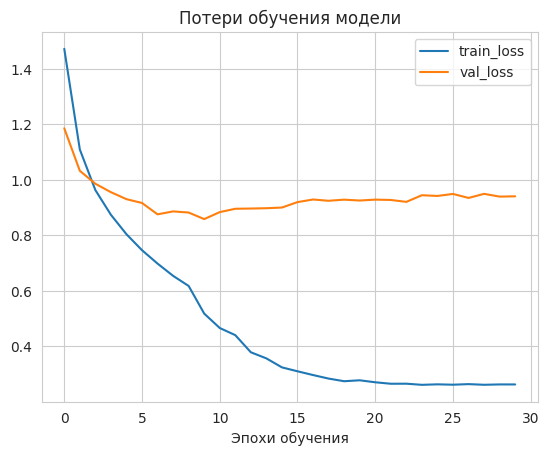

In [ ]:
loss_labels = ["train_loss", "val_loss"]

for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.title("Потери обучения модели")
    plt.xlabel("Эпохи обучения")
plt.legend()

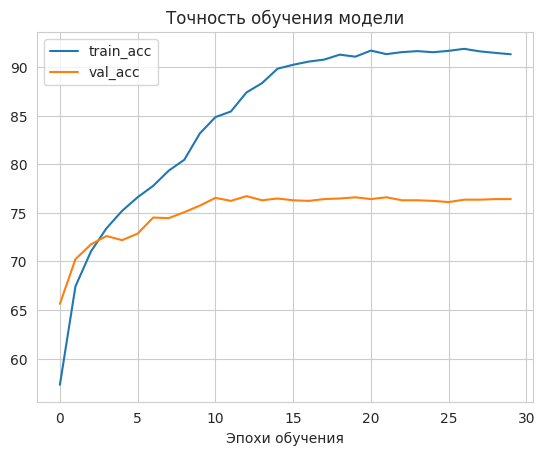

In [ ]:
acc_labels = ["train_acc", "val_acc"]
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.title("Точность обучения модели")
    plt.xlabel("Эпохи обучения")
plt.legend()

In [ ]:
y#точность до переобучения -  76.7156862745098, что соответсвует 12 эпохе

[65.625,
 70.22058823529413,
 71.75245098039215,
 72.61029411764709,
 72.18137254901961,
 72.85539215686278,
 74.50980392156865,
 74.44852941176474,
 75.06127450980391,
 75.73529411764707,
 76.53186274509802,
 76.22549019607844,
 76.7156862745098,
 76.28676470588235,
 76.47058823529413,
 76.28676470588238,
 76.22549019607845,
 76.4093137254902,
 76.47058823529409,
 76.59313725490198,
 76.40931372549022,
 76.59313725490196,
 76.28676470588233,
 76.28676470588233,
 76.22549019607844,
 76.1029411764706,
 76.3480392156863,
 76.34803921568627,
 76.40931372549018,
 76.4093137254902]

 Точность модели на валидационной выборке возросла до **76.72**. Однако визуально мы можем наблюдать больший разрыв между графиками точности валидационной и тренировочной выборок по сравнению с предыдущими моделями.

 После 12 эпохи происходит переобучение, тк разница в точности на тренировочном наборе данных и валидационном составляет ~15. Тем не менее, измененная модель более устойчива к переобучению. Это связано с тем, что она начинает переобучаться позже, после 12 эпох, по сравнению с предыдущими моделями.

### Целевые метки в датасете не сбалансированы.

Для учета весов классов в функцию потерь CrossEntropyLoss передают аргумент с
соответствующими весами.

dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)

##### Проделаем эти действия с бейзлайн моделью

In [ ]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=64,
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [ ]:
classifier = SurnameClassifier(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}
import time as t
t1 = t.perf_counter()

try:
    for epoch_index in tqdm(range(args.num_epochs)):
        train_state['epoch_index'] = epoch_index

        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                            batch_size=args.batch_size,
                                            device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            optimizer.zero_grad()
            y_pred = classifier(x_in=batch_dict['x_data'],
                                x_lengths=batch_dict['x_length'])

            loss = loss_func(y_pred, batch_dict['y_target'])

            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            loss.backward()

            optimizer.step()
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                          batch_size=args.batch_size,
                                          device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            y_pred = classifier(x_in=batch_dict['x_data'],
                                x_lengths=batch_dict['x_length'])

            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        scheduler.step(train_state['val_loss'][-1])
        '''
        if train_state['stop_early']:
            break
        '''
except KeyboardInterrupt:
    print("Exiting loop")


print('-----')
t2 = t.perf_counter()
print("Running time = {:.2f}".format(t2-t1))


  0%|          | 0/25 [00:00<?, ?it/s]

-----
Running time = 66.43


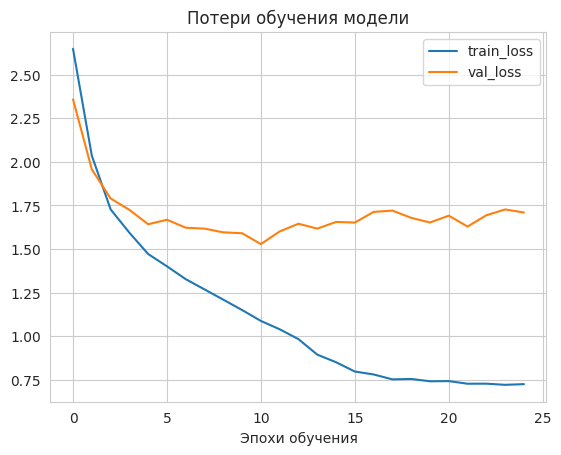

In [ ]:
loss_labels = ["train_loss", "val_loss"]

for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.title("Потери обучения модели")
    plt.xlabel("Эпохи обучения")
plt.legend()

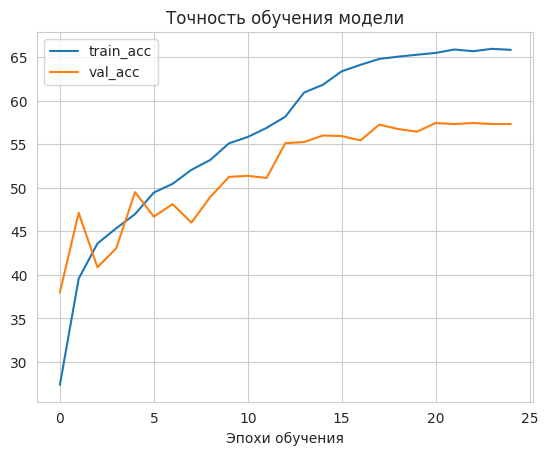

In [ ]:
acc_labels = ["train_acc", "val_acc"]
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.title("Точность обучения модели")
    plt.xlabel("Эпохи обучения")
plt.legend()

In [ ]:
y

[37.99999999999999,
 47.12500000000001,
 40.87499999999999,
 43.06249999999999,
 49.5,
 46.68750000000001,
 48.125,
 46.00000000000001,
 48.9375,
 51.25000000000001,
 51.37500000000001,
 51.12500000000001,
 55.12499999999999,
 55.250000000000014,
 56.0,
 55.9375,
 55.437500000000014,
 57.24999999999999,
 56.75000000000001,
 56.437499999999986,
 57.4375,
 57.31249999999999,
 57.437500000000014,
 57.31249999999999,
 57.31250000000001]

Как изменились потери/точность при обучении при наличии/отсутствии аргумента
с весами классов? Чем можно объяснить данные изменения?

Точность модели значительно снизилась при наличии аргумента с весами классов, примерно на 20%. Одним из объяснений может являться недостаточное количество данных. Некоторые классы представлены недостаточно в обучающем наборе данных, поэтому веса классов не улучшают производительность модели. Модель не получает достаточно информации для обучения на этих классах.

### Оценка предсказаний

In [ ]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)

    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)

    index = indices.item()
    prob_value = probability_values.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return {'nationality': predicted_nationality, 'probability': prob_value, 'surname': surname}


In [ ]:
# surname = input("Enter a surname: ")
classifier = classifier.to("cpu")
for surname in ['McMahan', 'Nakamoto', 'Wan', 'Cho']:
    print(predict_nationality(surname, classifier, vectorizer))


{'nationality': 'Irish', 'probability': 0.7678006887435913, 'surname': 'McMahan'}
{'nationality': 'Japanese', 'probability': 0.9800524711608887, 'surname': 'Nakamoto'}
{'nationality': 'Chinese', 'probability': 0.7162925601005554, 'surname': 'Wan'}
{'nationality': 'Korean', 'probability': 0.6000786423683167, 'surname': 'Cho'}


In [ ]:
predict_nationality('Nedobezhkin', classifier, vectorizer)

{'nationality': 'Russian',
 'probability': 0.9816584587097168,
 'surname': 'Nedobezhkin'}

In [ ]:
predict_nationality('Vinnichenko', classifier, vectorizer)

{'nationality': 'Russian',
 'probability': 0.9103266000747681,
 'surname': 'Vinnichenko'}

In [ ]:
predict_nationality('Vitko', classifier, vectorizer)

{'nationality': 'Russian',
 'probability': 0.7480090856552124,
 'surname': 'Vitko'}

In [ ]:
predict_nationality('Mendoza', classifier, vectorizer)

{'nationality': 'Spanish',
 'probability': 0.5845994353294373,
 'surname': 'Mendoza'}

In [ ]:
predict_nationality('Santaella', classifier, vectorizer)

{'nationality': 'Spanish',
 'probability': 0.5647897720336914,
 'surname': 'Santaella'}

In [ ]:
predict_nationality('Lokotar', classifier, vectorizer)

{'nationality': 'Czech',
 'probability': 0.42320385575294495,
 'surname': 'Lokotar'}

In [ ]:
predict_nationality('Gal', classifier, vectorizer)

{'nationality': 'Dutch', 'probability': 0.4008128046989441, 'surname': 'Gal'}

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Filter the dataset to get the validating split
validating_df = df[df['split'] == 'val']

# Count the number of objects for each class in the validating split
class_counts = validating_df['nationality'].value_counts()

# Plot the bar chart
fig = go.Figure(go.Bar(
    x=class_counts.index,
    y=class_counts.values,
    marker_color='skyblue'
))

# Customize the layout
fig.update_layout(
    title='Objects Quantity by Classes in the Validating Data Set',
    xaxis=dict(title='Class'),
    yaxis=dict(title='Quantity')
)

# Show the plot
fig.show()


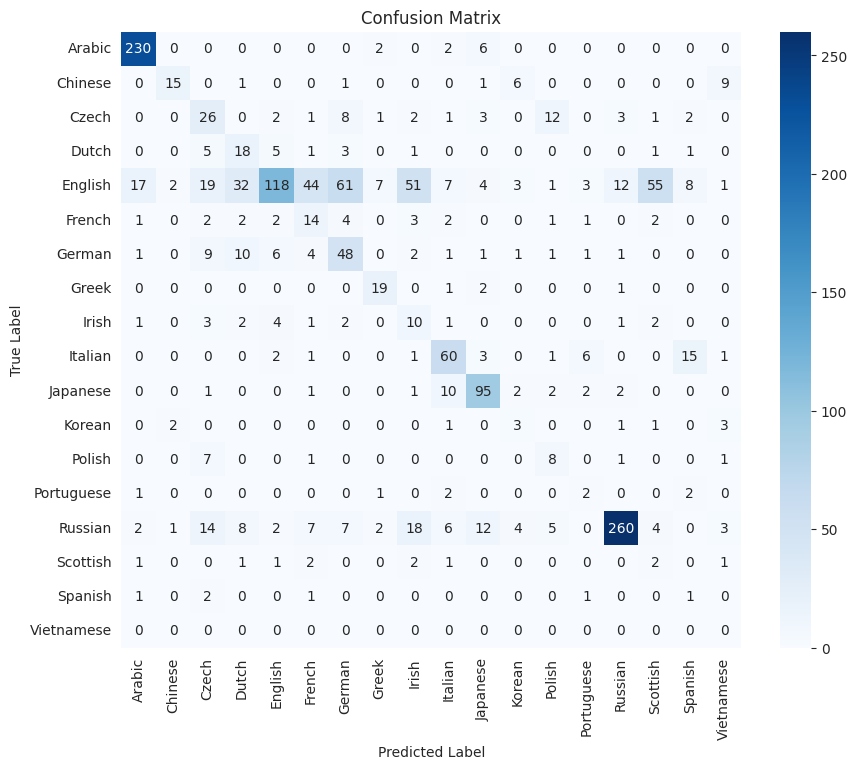

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Установка модели в режим предсказания
classifier.eval()

# Создание пустого списка для хранения предсказанных и фактических меток
all_predictions = []
all_targets = []

# Создание генератора батчей для тестового набора данных
dataset.set_split('val')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device,
                                   shuffle=False)

# Проход по всем батчам тестового набора данных и сбор предсказаний и фактических меток
for batch_index, batch_dict in enumerate(batch_generator):
    # Получение предсказаний модели
    y_pred = classifier(batch_dict['x_data'], batch_dict['x_length'], apply_softmax=True)
    _, predicted_indices = y_pred.max(dim=1)
    all_predictions.extend(predicted_indices.cpu().numpy())
    all_targets.extend(batch_dict['y_target'].cpu().numpy())

# Построение матрицы ошибок
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Визуализация матрицы ошибок с помощью seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=vectorizer.nationality_vocab._idx_to_token.values(),
            yticklabels=vectorizer.nationality_vocab._idx_to_token.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Рассчитываем точность модели
accuracy = accuracy_score(all_targets, all_predictions)

# Рассчитываем precision, recall и F1-score для каждого класса
precision = precision_score(all_targets, all_predictions, average=None)
recall = recall_score(all_targets, all_predictions, average=None)
f1 = f1_score(all_targets, all_predictions, average=None)

# Выводим результаты
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 58.06%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [ ]:
import pandas as pd

# Создаем DataFrame для хранения результатов
results_df = pd.DataFrame({
    'Class': range(len(class_names)),
    'Nationality': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
})


In [ ]:
## Создаем копию DataFrame для стилизации
styled_results_df = results_df.copy()
# Применяем стиль для подсветки значений F1-score > 0.7 и < 0.4
styled_results_df = styled_results_df.style.applymap(lambda x: 'background-color: lightgreen' if x > 0.7 else ('background-color: red' if x < 0.3 else ''), subset=['F1-score'])

# Выводим стилизованную таблицу
styled_results_df


,Class,Nationality,Precision,Recall,F1-score
0,0,Arabic,0.901961,0.958333,0.929293
1,1,Chinese,0.750000,0.454545,0.566038
2,2,Czech,0.295455,0.419355,0.346667
3,3,Dutch,0.243243,0.514286,0.330275
4,4,English,0.830986,0.265169,0.402044
5,5,French,0.179487,0.411765,0.250000
6,6,German,0.358209,0.558140,0.436364
7,7,Greek,0.593750,0.826087,0.690909
8,8,Irish,0.109890,0.370370,0.169492
9,9,Italian,0.631579,0.666667,0.648649


- Какие национальности определяются лучше всего?

**Ответ**: Лучше всего предсказываются Arabic, Russian, Japanese фамилии.


- С чем это может быть связано?

**Ответ:**  в обучающем наборе есть достаточное количество примеров для Arabic, Russian и Japanese фамилий. Приведенная ниже статистика показывает, что Russian и Arabic занимают 21.63% и 14.61% тренировочной выборки.

**Интерсное наблюдение об Englsih.** Этот класс является самым популярным в тренировочной выборке, 27.08%. Однако показатели F1-score достаточно посредственная - 0.402044. Связываю это с историческими изменениями и схожестью фамилий. Английские фамилии могут быть похожими на фамилии из других культур из-за процессов иммиграции и смешения культурных групп. Кроме того, исторические изменения в английских фамилиях могли привести к разнообразию происхождения и форм фамилий, что усложняет задачу их классификации.


- Можно ли выделить группы национальностей в которых алгоритм путается больше
всего? С чем это может быть связано?

**Ответ:** Алгоритм путается больше всего в Vietnamese, Scottish, Spanish, Portuguese, Irish, Korean, French. Могут быть выделены следующие причины:
1. **Недостаток обучающих данных**: Модель может испытывать затруднения в правильном обучении для определенных категорий из-за недостатка обучающих данных для этих конкретных национальностей. Например, показатели для слеудющих национальностей, дейстивтельно, малы относительно остальной массы (Scottish      0.006771, Vietnamese    0.005208, Portuguese    0.004948).
2. Также нам встречалась следующая ошибка: **Recall is ill-defined** and being set to 0.0 in labels with no true samples. Это означает, в некотором классе отсутствуют истинные метки. Это может произойти, если в валидационном наборе данных отсутствуют объекты для определенного класса. Так и произошло например для Vietnamese. Согласно графику 'Objects Quantity by Classes in the Validating Data Set' 0 наблюдейний было отобрано в валидационную выборку (однако спустя несколько часов и еще одной прогонки кода они появились, что странно, тк warning остался:)).
3. **Фонетическая схожесть**: Некоторые фамилии из разных культур могут иметь схожие фонетические характеристики, что затрудняет их различение для модели. Например, в перечисленном мною списке плохо опредялемых фамилий присутсвуют French и Spanish, а также Scottish и Irish, которые могут имет фонетичнскую схожесть.

In [ ]:

# Группировка данных по национальности и подсчет их количества для категории train
train_counts = df[df['split'] == 'train']['nationality'].value_counts(normalize=True)

# Сортируем результаты по популярности в убывающем порядке
train_counts_sorted = train_counts.sort_values(ascending=False)

# Выводим отсортированные результаты
print(train_counts_sorted)


English       0.270833
Russian       0.216276
Arabic        0.146094
Japanese      0.070573
Italian       0.054688
German        0.052474
Czech         0.037630
Spanish       0.023438
Dutch         0.021484
French        0.020833
Chinese       0.020052
Irish         0.016667
Greek         0.014193
Polish        0.010937
Korean        0.006901
Scottish      0.006771
Vietnamese    0.005208
Portuguese    0.004948
Name: nationality, dtype: float64


In [ ]:
import numpy as np

# Получаем уникальные значения и их частоту для истинных меток
unique_labels, label_counts = np.unique(all_targets, return_counts=True)

# Создаем словарь для хранения частоты меток по классам
label_counts_dict = dict(zip(unique_labels, label_counts))

# Выводим частоту меток по классам
for label, count in label_counts_dict.items():
    print(f"Class {label}: {count} samples")

# Проверяем наличие классов без истинных меток
classes_without_samples = [label for label, count in label_counts_dict.items() if count == 0]
if classes_without_samples:
    print("Classes without true samples:", classes_without_samples)
else:
    print("All classes have true samples.")


Class 0: 240 samples
Class 1: 33 samples
Class 2: 62 samples
Class 3: 35 samples
Class 4: 445 samples
Class 5: 34 samples
Class 6: 86 samples
Class 7: 23 samples
Class 8: 27 samples
Class 9: 90 samples
Class 10: 116 samples
Class 11: 11 samples
Class 12: 18 samples
Class 13: 8 samples
Class 14: 355 samples
Class 15: 11 samples
Class 16: 6 samples
All classes have true samples.
